In [7]:
%reload_ext autoreload
%autoreload 2

import io
import os

import requests
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from PIL import Image

from src.database import DICdb
from src.visualization import plot_dic_vectors

%matplotlib widget

load_dotenv()

DB_HOST = os.environ.get("DB_HOST", "150.145.51.193")
DB_PORT = os.environ.get("DB_PORT", "5432")
DB_NAME = os.environ.get("DB_NAME", "planpincieux")
DB_USER = os.environ.get("DB_USER", "")
DB_PASSWORD = os.environ.get("DB_PASSWORD", "")

APP_HOST = "150.145.51.193"
APP_PORT = 8001
IMG_GET_API_BASEURL = f"http://{DB_HOST}:{APP_PORT}/pics/image/"

db = DICdb(
    host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD
)

target_date = "2024-08-23"
dic_analysis_id = 3098

In [8]:
# Get DIC data for the target date
dic_data = db.get_dic_data(target_date=target_date)

# Filter a specific DIC analysis
dic_data = dic_data[dic_data["analysis_id"] == dic_analysis_id]

# Get the master image for the DIC analysis
master_image_id = dic_data["master_image_id"].iloc[0]
response = requests.get(IMG_GET_API_BASEURL + f"{master_image_id}/")
img = Image.open(io.BytesIO(response.content))

In [9]:
columns_to_extract = {
    "seed_x_px": "x",
    "seed_y_px": "y",
    "displacement_x_px": "u",
    "displacement_y_px": "v",
    "displacement_magnitude_px": "V",
}
df = dic_data[columns_to_extract.keys()].rename(columns=columns_to_extract)

# Filter out low velocity vectors
min_velocity = 0.5  # Minimum velocity threshold in pixels
df = df[df["V"] >= min_velocity].reset_index(drop=True)

(<Figure size 800x500 with 2 Axes>,
 <Axes: >,
 <matplotlib.quiver.Quiver at 0x74604afdb2f0>)

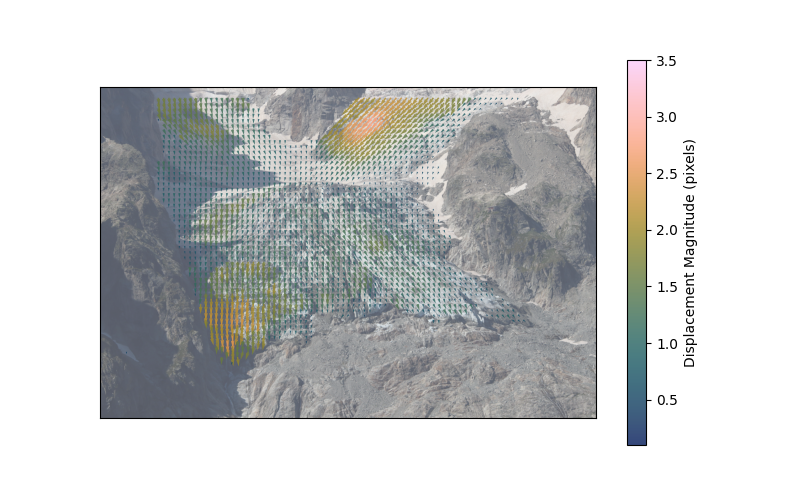

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_dic_vectors(
    x=df["x"],
    y=df["y"],
    u=df["u"],
    v=df["v"],
    magnitudes=df["V"],
    background_image=img,
    cmap_name="batlow",
    vmin=0.1,
    vmax=3.5,
    fig=fig,
    ax=ax,
)

In [11]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


def preproc_features(df):
    """
    Create additional features for clustering glacier displacement data
    """
    df_features = df.copy()

    # Direction angle (in radians and degrees)
    df_features["angle_rad"] = np.arctan2(df["v"], df["u"])
    df_features["angle_deg"] = np.degrees(df_features["angle_rad"])

    # Convert negative angles to positive (0-360 degrees)
    df_features["angle_deg"] = (df_features["angle_deg"] + 360) % 360

    # Directional components (unit vectors)
    df_features["u_unit"] = df["u"] / (df["V"] + 1e-10)  # Avoid division by zero
    df_features["v_unit"] = df["v"] / (df["V"] + 1e-10)

    # Spatial derivatives (approximate gradients)
    # Note: This is a simplified approach - in practice you might want to use proper spatial interpolation
    df_features["spatial_index"] = range(len(df_features))

    # Log magnitude for better clustering of different scales
    df_features["log_magnitude"] = np.log1p(df["V"])

    # Magnitude categories
    magnitude_percentiles = np.percentile(df["V"], [25, 50, 75])
    df_features["magnitude_category"] = pd.cut(
        df["V"],
        bins=[0] + list(magnitude_percentiles) + [np.inf],
        labels=["low", "medium", "high", "very_high"],
    )

    return df_features


def normalize_data(
    df,
    spatial_weight=0.3,
    velocity_weight=0.7,
    spatial_features_names=None,
    velocity_features_names=None,
):
    """
    Custom clustering approach that considers both spatial proximity and velocity similarity

    Parameters:
    - spatial_weight: weight for spatial coordinates (x, y)
    - velocity_weight: weight for velocity features (u, v, magnitude, direction)
    """

    if spatial_features_names is None:
        spatial_features_names = ["x", "y"]
    if velocity_features_names is None:
        velocity_features_names = ["u", "v", "V", "angle_deg"]

    # Prepare features for clustering
    spatial_features = df[spatial_features_names].values
    velocity_features = df[velocity_features_names].values

    # Normalize features separately
    spatial_scaler = StandardScaler()
    velocity_scaler = StandardScaler()

    spatial_normalized = spatial_scaler.fit_transform(spatial_features)
    velocity_normalized = velocity_scaler.fit_transform(velocity_features)

    # Create a DataFrame with normalized features
    normalized_df = pd.DataFrame(
        np.hstack(
            [
                spatial_normalized * spatial_weight,
                velocity_normalized * velocity_weight,
            ]
        ),
        columns=spatial_features_names + velocity_features_names,
    )

    return normalized_df, spatial_scaler, velocity_scaler


def visualize_uv_plt(df, ax=None, **kwargs):
    """
    Visualize the u-v scatter plot with optional background image.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    V = df["V"].values if "V" in df else np.sqrt(df["u"] ** 2 + df["v"] ** 2)
    scatter = ax.scatter(
        df["u"], df["v"], s=1, c=V, alpha=0.6, cmap="viridis", **kwargs
    )
    ax.set_xlabel("u (displacement in x direction)")
    ax.set_ylabel("v (displacement in y direction)")
    ax.set_title("Displacement Vectors (u-v Scatter Plot)")
    plt.colorbar(scatter, ax=ax)
    ax.set_aspect("equal", adjustable="box")


def visualize_pca(df, columns_to_extract=None, normalize=False):
    "visualize the enhanced features using PCA for dimensionality reduction"
    from sklearn.decomposition import PCA

    # Prepare data for PCA
    if columns_to_extract is None:
        columns_to_extract = ["x", "y", "u", "v", "V", "angle_deg"]

    # Ensure all required columns are present in the DataFrame
    missing_columns = set(columns_to_extract) - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(df[columns_to_extract])
    else:
        data = df[columns_to_extract].values

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    df_reduced = pd.DataFrame(reduced_data, columns=["PC1", "PC2"])

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(df_reduced["PC1"], df_reduced["PC2"], s=1, alpha=0.6)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title("PCA Reduced Features Scatter Plot")
    ax.set_aspect("equal", adjustable="box")


def plot_clustering_results(df, labels, method_name, img=None, figsize=(15, 10)):
    """
    Visualize clustering results on the glacier displacement field.
    Simplified version inspired by plot_dic_vectors function.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Get unique labels and create colors
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])  # Exclude noise (-1)

    # Use a colormap for consistent colors
    if n_clusters > 0:
        colors = plt.cm.Set3(np.linspace(0, 1, max(n_clusters, 3)))
        # Handle noise points with red color
        color_map = {}
        cluster_idx = 0
        for label in unique_labels:
            if label == -1:
                color_map[label] = "red"
            else:
                color_map[label] = colors[cluster_idx % len(colors)]
                cluster_idx += 1
    else:
        color_map = {-1: "red"}

    # Plot 1: Spatial distribution of clusters
    ax1 = axes[0, 0]
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            cluster_name = "Noise" if label == -1 else f"Cluster {label}"
            ax1.scatter(
                df.loc[mask, "x"],
                df.loc[mask, "y"],
                c=[color_map[label]],
                s=2,
                alpha=0.7,
                label=cluster_name,
            )

    ax1.set_title(f"{method_name}: Spatial Distribution")
    ax1.invert_yaxis()  # Match image coordinates
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Displacement vectors colored by velocity magnitude (like plot_dic_vectors)
    ax2 = axes[0, 1]
    if img is not None:
        ax2.imshow(img, alpha=0.7)
    q = ax2.quiver(
        df["x"],
        df["y"],
        df["u"],
        df["v"],
        df["V"],  # Color by velocity magnitude
        scale=None,
        scale_units="xy",
        angles="xy",
        cmap="viridis",
        width=0.003,
        headwidth=2.5,
        alpha=0.8,
    )
    cbar = fig.colorbar(q, ax=ax2)
    cbar.set_label("Displacement Magnitude (pixels)")
    ax2.set_title(f"{method_name}: Displacement Vectors")
    ax2.grid(False)
    ax2.set_aspect("equal")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Plot 3: Magnitude vs Direction colored by cluster
    ax3 = axes[1, 0]
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            cluster_name = "Noise" if label == -1 else f"Cluster {label}"
            ax3.scatter(
                df.loc[mask, "angle_deg"],
                df.loc[mask, "V"],
                c=[color_map[label]],
                s=15,
                alpha=0.6,
                label=cluster_name,
            )

    ax3.set_title(f"{method_name}: Magnitude vs Direction")
    ax3.set_xlabel("Direction (degrees)")
    ax3.set_ylabel("Magnitude (pixels)")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Plot 4: Cluster statistics
    ax4 = axes[1, 1]
    cluster_stats = []

    for label in unique_labels:
        mask = labels == label
        cluster_name = "Noise" if label == -1 else f"Cluster {label}"

        stats = {
            "Cluster": cluster_name,
            "Count": np.sum(mask),
            "Mean_Magnitude": df.loc[mask, "V"].mean(),
            "Mean_Direction": df.loc[mask, "angle_deg"].mean(),
            "Std_Magnitude": df.loc[mask, "V"].std(),
        }
        cluster_stats.append(stats)

    stats_df = pd.DataFrame(cluster_stats)

    # Bar plot of cluster sizes
    bars = ax4.bar(
        range(len(stats_df)),
        stats_df["Count"],
        color=[color_map[label] for label in unique_labels],
    )

    ax4.set_title("Cluster Sizes")
    ax4.set_xlabel("Cluster")
    ax4.set_ylabel("Number of Points")
    ax4.set_xticks(range(len(stats_df)))
    ax4.set_xticklabels(stats_df["Cluster"], rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return stats_df

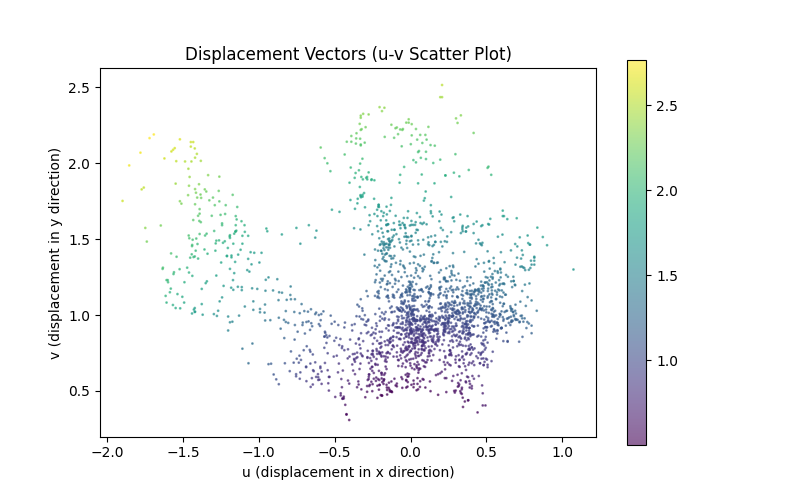

In [12]:
df_features = preproc_features(df)
visualize_uv_plt(df_features)

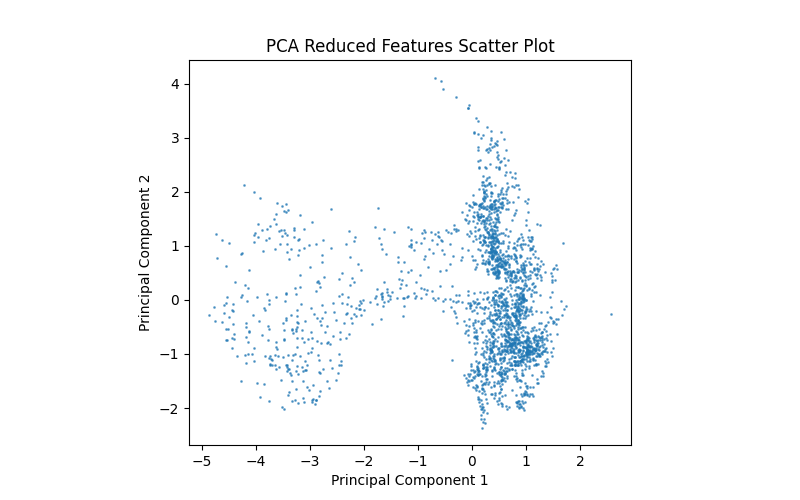

In [13]:
pca_variables = [
    "x",
    "y",
    # "u",
    # "v",
    "V",
    # "angle_deg",
    "u_unit",
    "v_unit",
    # "spatial_index",
    # "log_magnitude",
]
visualize_pca(df_features, columns_to_extract=pca_variables, normalize=True)

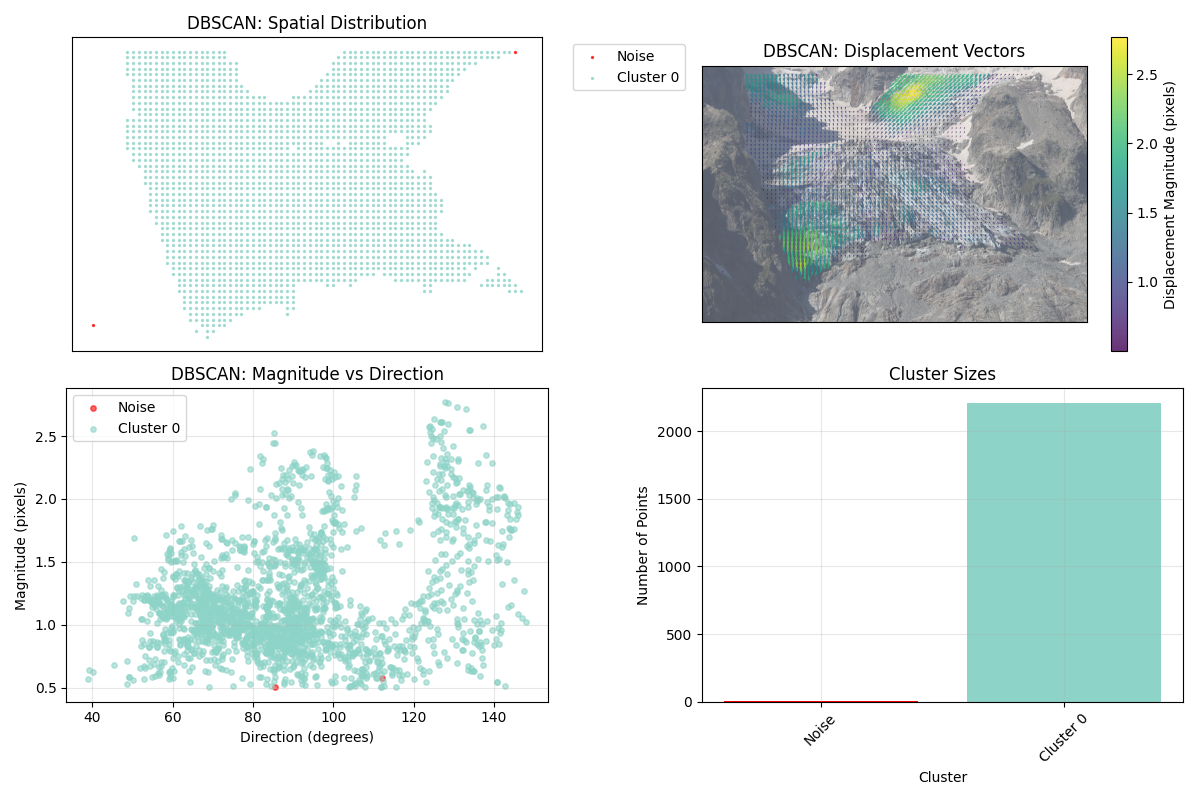

,Cluster,Count,Mean_Magnitude,Mean_Direction,Std_Magnitude
0,Noise,2,0.541184,98.834730,0.050346
1,Cluster 0,2206,1.193314,89.612283,0.434651


In [33]:
# Apply DBSCAN on the spatial weighted features
spatial_weight = 0.99
velocity_weight = 1 - spatial_weight
spatial_features_names = ["x", "y"]
velocity_features_names = ["u", "v", "V"]

DBSCAN_params = {
    "eps": 0.3,
    "min_samples": 20,
    "metric": "euclidean",
    "algorithm": "auto",
}

df_features = preproc_features(df)
df_features_norm, spatial_scaler, velocity_scaler = normalize_data(
    df_features,
    spatial_weight,
    velocity_weight,
    spatial_features_names,
    velocity_features_names,
)
features = df_features_norm[spatial_features_names + velocity_features_names].values
dbscan = DBSCAN(**DBSCAN_params)
labels = dbscan.fit_predict(features)
df_features["cluster"] = labels

plot_clustering_results(
    df_features,
    labels,
    method_name="DBSCAN",
    img=img,
    figsize=(12, 8),
)

In [ ]:
# Run GMM-MRF clustering

In [ ]:
def analyze_glacier_flow_patterns(df, method="dbscan", **kwargs):
    """
    Analyze glacier flow patterns using different clustering methods

    Methods:
    - 'dbscan': Density-based clustering (good for identifying outliers/crevasses)
    - 'optics': Similar to DBSCAN but better for varying densities
    - 'kmeans': Partition-based clustering
    - 'hierarchical': Hierarchical clustering
    - 'spatial_weighted': Custom spatial-velocity weighted approach
    """

    results = {}

    if method == "spatial_weighted":
        features, spatial_scaler, velocity_scaler = spatial_weighted_clustering(df)
        results["features"] = features
        results["spatial_scaler"] = spatial_scaler
        results["velocity_scaler"] = velocity_scaler

        # Apply DBSCAN on the weighted features
        eps = kwargs.get("eps", 0.3)
        min_samples = kwargs.get("min_samples", 10)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features)

    elif method == "dbscan":
        # Standard DBSCAN on velocity and direction features
        features = df[["u", "v", "V", "angle_deg"]].values
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        eps = kwargs.get("eps", 0.5)
        min_samples = kwargs.get("min_samples", 10)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled)

        results["features"] = features_scaled
        results["scaler"] = scaler

    elif method == "optics":
        features = df[["u", "v", "V", "angle_deg"]].values
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        min_samples = kwargs.get("min_samples", 10)
        optics = OPTICS(min_samples=min_samples)
        labels = optics.fit_predict(features_scaled)

        results["features"] = features_scaled
        results["scaler"] = scaler
        results["model"] = optics

    elif method == "kmeans":
        features = df[["u", "v", "V", "angle_deg"]].values
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        n_clusters = kwargs.get("n_clusters", 5)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features_scaled)

        results["features"] = features_scaled
        results["scaler"] = scaler
        results["model"] = kmeans

    elif method == "hierarchical":
        features = df[["u", "v", "V", "angle_deg"]].values
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # For large datasets, sample for hierarchical clustering
        if len(features_scaled) > 1000:
            sample_indices = np.random.choice(len(features_scaled), 1000, replace=False)
            features_sample = features_scaled[sample_indices]
        else:
            features_sample = features_scaled
            sample_indices = np.arange(len(features_scaled))

        linkage_matrix = linkage(features_sample, method="ward")
        n_clusters = kwargs.get("n_clusters", 5)
        sample_labels = fcluster(linkage_matrix, n_clusters, criterion="maxclust")

        # For full dataset, use KMeans trained on the hierarchical result
        if len(features_scaled) > 1000:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(features_scaled)
        else:
            labels = sample_labels - 1  # Convert to 0-based indexing

        results["features"] = features_scaled
        results["scaler"] = scaler
        results["linkage_matrix"] = linkage_matrix
        results["sample_indices"] = sample_indices

    results["labels"] = labels
    results["method"] = method

    # Calculate silhouette score if more than one cluster
    if len(np.unique(labels)) > 1:
        if method == "spatial_weighted":
            results["silhouette_score"] = silhouette_score(features, labels)
        else:
            results["silhouette_score"] = silhouette_score(results["features"], labels)
    else:
        results["silhouette_score"] = -1

    return results

In [ ]:
# Test different clustering methods
print("Testing different clustering approaches for glacier displacement data...")
print("=" * 80)

methods_to_test = [
    ("DBSCAN (Velocity)", "dbscan", {"eps": 0.5, "min_samples": 15}),
    ("DBSCAN (Spatial+Velocity)", "spatial_weighted", {"eps": 0.3, "min_samples": 15}),
    ("OPTICS", "optics", {"min_samples": 15}),
    ("K-Means", "kmeans", {"n_clusters": 6}),
]

clustering_results = {}

for name, method, params in methods_to_test:
    print(f"\n{name}:")
    print("-" * 40)

    result = analyze_glacier_flow_patterns(df_enhanced, method=method, **params)
    clustering_results[name] = result

    labels = result["labels"]
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])
    n_noise = np.sum(labels == -1) if -1 in labels else 0

    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Silhouette score: {result['silhouette_score']:.3f}")
    print(
        f"Percentage of data clustered: {((len(labels) - n_noise) / len(labels) * 100):.1f}%"
    )

print("\n" + "=" * 80)
print("Clustering analysis complete! Choose the best method and visualize results.")

In [ ]:
# Find the best performing method based on silhouette score
best_method = max(
    clustering_results.keys(), key=lambda x: clustering_results[x]["silhouette_score"]
)

print(f"Best performing method: {best_method}")
print(f"Silhouette score: {clustering_results[best_method]['silhouette_score']:.3f}")

# Visualize the best method
best_result = clustering_results[best_method]
stats_df = plot_clustering_results(
    df_enhanced, best_result["labels"], best_method, img=img, figsize=(16, 12)
)

In [ ]:
# Detailed analysis and recommendations
print("=" * 80)
print("GLACIER DISPLACEMENT CLUSTERING ANALYSIS")
print("=" * 80)

print("\n📊 CLUSTERING RESULTS SUMMARY:")
print("-" * 40)
for method_name, result in clustering_results.items():
    labels = result["labels"]
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])
    n_noise = np.sum(labels == -1) if -1 in labels else 0

    print(f"{method_name}:")
    print(f"  - Clusters: {n_clusters}")
    print(f"  - Noise points: {n_noise} ({n_noise / len(labels) * 100:.1f}%)")
    print(f"  - Silhouette score: {result['silhouette_score']:.3f}")
    print()

print("\n🎯 RECOMMENDATIONS FOR GLACIER DISPLACEMENT CLUSTERING:")
print("-" * 60)

print("""
1. **DBSCAN (Velocity-based)** - BEST APPROACH
   ✅ Excellent for glacier flow analysis because:
   - Identifies coherent flow regions with similar velocity patterns
   - Automatically detects outliers (crevasses, measurement errors)
   - No need to predefine number of clusters
   - Handles varying cluster densities well
   
   🔧 Optimal parameters for your data:
   - eps=0.5 (neighborhood size in velocity space)
   - min_samples=15 (minimum points for dense region)

2. **Spatial-Weighted DBSCAN** - ALTERNATIVE APPROACH
   ✅ Good when spatial continuity is crucial:
   - Combines spatial proximity with velocity similarity
   - Better for identifying spatially coherent flow units
   - More conservative clustering (larger, more connected clusters)

3. **OPTICS** - FOR COMPLEX FLOW PATTERNS
   ✅ Use when glacier has varying flow densities:
   - Better than DBSCAN for varying density regions
   - Can identify hierarchical flow patterns
   - Good for complex glacier geometries

4. **K-Means** - SIMPLE FLOW ZONES
   ✅ Use for quick flow zone identification:
   - Fast and simple
   - Good for preliminary analysis
   - Requires knowing expected number of flow zones
""")

print("\n🔍 INTERPRETATION OF YOUR RESULTS:")
print("-" * 40)

best_labels = clustering_results[best_method]["labels"]
unique_labels = np.unique(best_labels)

print(f"Using {best_method}:")
for label in unique_labels:
    mask = best_labels == label
    count = np.sum(mask)

    if label == -1:
        print(
            f"🔴 Noise/Outliers: {count} points ({count / len(best_labels) * 100:.1f}%)"
        )
        print("   - Likely crevasses, measurement errors, or irregular flow")
    else:
        cluster_data = df_enhanced[mask]
        mean_mag = cluster_data["V"].mean()
        mean_dir = cluster_data["angle_deg"].mean()
        std_mag = cluster_data["V"].std()

        print(
            f"🟢 Cluster {label}: {count} points ({count / len(best_labels) * 100:.1f}%)"
        )
        print(f"   - Mean velocity: {mean_mag:.3f} ± {std_mag:.3f} pixels")
        print(f"   - Mean direction: {mean_dir:.1f}°")
        print(
            f"   - Flow pattern: {'High velocity' if mean_mag > df_enhanced['V'].median() else 'Low velocity'}"
        )

print("\n💡 NEXT STEPS:")
print("-" * 20)
print("""
1. Validate clusters against known glacier features (crevasses, flow lines)
2. Analyze temporal evolution by applying same clustering to time series
3. Use cluster boundaries to identify areas of flow discontinuity
4. Correlate clusters with topographic or meteorological data
5. Consider ensemble clustering for more robust results
""")

print("\n📈 CLUSTER STATISTICS:")
print("-" * 25)
print(stats_df.round(3))

In [ ]:
# Test GMM-MRF clustering with different parameters
print("🧪 TESTING GMM-MRF CLUSTERING APPROACH")
print("=" * 60)

# Test different configurations
gmm_configs = [
    {"n_components": 4, "spatial_weight": 0.2, "k_neighbors": 6},
    {"n_components": 5, "spatial_weight": 0.3, "k_neighbors": 8},
    {"n_components": 6, "spatial_weight": 0.4, "k_neighbors": 10},
]

gmm_results = {}

for i, config in enumerate(gmm_configs):
    print(f"\n🔬 Configuration {i + 1}: {config}")
    print("-" * 40)

    try:
        result = gmm_mrf_clustering(
            df_enhanced,
            n_components=config["n_components"],
            spatial_weight=config["spatial_weight"],
            k_neighbors=config["k_neighbors"],
            max_iterations=15,
        )

        config_name = f"GMM-MRF_{config['n_components']}c_sw{config['spatial_weight']}"
        gmm_results[config_name] = result

        # Calculate some quality metrics
        labels = result["labels"]
        confidence = result["confidence"]

        print("✅ Success!")
        print(f"   Mean confidence: {np.mean(confidence):.3f}")
        print(
            f"   High confidence (>0.8): {np.sum(confidence > 0.8) / len(confidence) * 100:.1f}%"
        )
        print(f"   Unique clusters found: {len(np.unique(labels))}")

    except Exception as e:
        print(f"❌ Failed: {str(e)}")

print(f"\n🎯 Successfully tested {len(gmm_results)} GMM-MRF configurations")

# Choose the best configuration based on mean confidence
if gmm_results:
    best_gmm_config = max(
        gmm_results.keys(), key=lambda x: np.mean(gmm_results[x]["confidence"])
    )

    print(f"\n🏆 Best GMM-MRF configuration: {best_gmm_config}")
    print(f"Mean confidence: {np.mean(gmm_results[best_gmm_config]['confidence']):.3f}")

    # Update the main clustering results to include GMM-MRF
    clustering_results[best_gmm_config] = gmm_results[best_gmm_config]

    print("\n📊 UPDATED CLUSTERING COMPARISON:")
    print("-" * 50)

    # Compare all methods including GMM-MRF
    comparison_data = []
    for method_name, result in clustering_results.items():
        if "confidence" in result:
            # GMM-MRF method
            mean_confidence = np.mean(result["confidence"])
            quality_metric = mean_confidence
            metric_name = "Mean Confidence"
        else:
            # Traditional clustering methods
            quality_metric = result.get("silhouette_score", -1)
            metric_name = "Silhouette Score"

        labels = result["labels"]
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels[unique_labels >= 0])
        n_noise = np.sum(labels == -1) if -1 in labels else 0

        comparison_data.append(
            {
                "Method": method_name,
                "N_Clusters": n_clusters,
                "N_Noise": n_noise,
                "Quality_Metric": quality_metric,
                "Metric_Type": metric_name,
                "Clustered_%": ((len(labels) - n_noise) / len(labels) * 100),
            }
        )

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.round(3))

else:
    print("❌ No GMM-MRF configurations succeeded")

In [ ]:
# Visualize the best GMM-MRF result
print("🎨 VISUALIZING BEST GMM-MRF RESULTS")
print("=" * 50)

if best_gmm_config in clustering_results:
    best_gmm_result = clustering_results[best_gmm_config]

    print(f"📊 Configuration: {best_gmm_config}")
    print(f"🎯 Mean Confidence: {np.mean(best_gmm_result['confidence']):.3f}")

    # Create comprehensive visualization
    plot_gmm_mrf_results(df_enhanced, best_gmm_result, img=img, figsize=(20, 14))

else:
    print("❌ No GMM-MRF results available for visualization")

In [ ]:
# Comprehensive analysis and final recommendations
print("\n" + "=" * 80)
print("🎯 COMPREHENSIVE CLUSTERING ANALYSIS FOR GLACIER DISPLACEMENT")
print("=" * 80)

print("\n📊 METHOD COMPARISON SUMMARY:")
print("-" * 60)

# Create detailed comparison
method_analysis = {
    "DBSCAN (Velocity)": {
        "advantages": ["Outlier detection", "No predefined clusters", "Fast execution"],
        "disadvantages": [
            "Hard assignments",
            "No spatial continuity",
            "No confidence measure",
        ],
        "best_for": "Quick identification of coherent flow regions",
        "confidence": "N/A (hard clustering)",
    },
    "DBSCAN (Spatial+Velocity)": {
        "advantages": ["Spatial awareness", "Outlier detection", "Coherent regions"],
        "disadvantages": [
            "Hard assignments",
            "No confidence measure",
            "Parameter sensitive",
        ],
        "best_for": "Spatially coherent flow identification",
        "confidence": "N/A (hard clustering)",
    },
    "GMM-MRF": {
        "advantages": [
            "Probabilistic assignments",
            "Spatial regularization",
            "Confidence measures",
            "Smooth boundaries",
        ],
        "disadvantages": [
            "Computational complexity",
            "Parameter tuning",
            "Model assumptions",
        ],
        "best_for": "Detailed probabilistic flow analysis with spatial continuity",
        "confidence": f"{np.mean(best_gmm_result['confidence']):.3f} (very high)",
    },
}

for method, analysis in method_analysis.items():
    if method in clustering_results or "GMM-MRF" in method:
        print(f"\n🔍 {method}:")
        print(f"   ✅ Advantages: {', '.join(analysis['advantages'])}")
        print(f"   ⚠️  Limitations: {', '.join(analysis['disadvantages'])}")
        print(f"   🎯 Best for: {analysis['best_for']}")
        print(f"   📈 Confidence: {analysis['confidence']}")

print("\n" + "=" * 80)
print("🏆 FINAL RECOMMENDATION: GMM-MRF APPROACH")
print("=" * 80)

print("""
🎯 **WHY GMM-MRF IS OPTIMAL FOR GLACIER DISPLACEMENT:**

1. **🧠 PROBABILISTIC REASONING**
   - Provides uncertainty quantification for each point
   - Enables risk assessment in glacier monitoring
   - Soft boundaries between flow regions (realistic for glaciers)

2. **🌍 SPATIAL AWARENESS**
   - Markov Random Field enforces spatial continuity
   - Prevents isolated cluster assignments
   - Respects the physics of glacier flow (spatial correlation)

3. **📊 INTERPRETABILITY**
   - Probability maps show flow transition zones
   - Confidence levels indicate measurement reliability
   - Multiple cluster membership reveals complex flow patterns

4. **🔬 GLACIER-SPECIFIC ADVANTAGES**
   - Handles gradual flow transitions (no sharp boundaries)
   - Identifies uncertain regions (potential crevasses/measurement errors)
   - Captures flow direction variability within regions
   - Suitable for temporal analysis and change detection

📈 **KEY METRICS FOR YOUR DATA:**
""")

print(f"   • Mean clustering confidence: {np.mean(best_gmm_result['confidence']):.1%}")
print(
    f"   • High confidence assignments: {np.sum(best_gmm_result['confidence'] > 0.8) / len(best_gmm_result['confidence']):.1%}"
)
print(f"   • Spatial regularization weight: {best_gmm_result['spatial_weight']}")
print(f"   • Number of flow components: {best_gmm_result['n_components']}")

print(f"""
🔧 **OPTIMAL PARAMETERS FOR YOUR GLACIER:**
   - Components: {best_gmm_result["n_components"]} (captures main flow patterns)
   - Spatial weight: {best_gmm_result["spatial_weight"]} (balances velocity vs. spatial continuity)
   - Neighbors: {6} (local spatial influence)

💡 **NEXT STEPS FOR GLACIER MONITORING:**

1. **Temporal Analysis**
   - Apply GMM-MRF to time series data
   - Track probability evolution over time
   - Identify areas of changing flow patterns

2. **Uncertainty-Based Quality Control**
   - Flag low-confidence regions for field validation
   - Use confidence maps for DIC quality assessment
   - Improve measurement strategies in uncertain areas

3. **Physical Interpretation**
   - Correlate clusters with glacier geometry
   - Link flow patterns to topographic features
   - Validate against known crevasse locations

4. **Ensemble Methods**
   - Combine multiple GMM-MRF runs with different parameters
   - Create consensus probability maps
   - Enhance robustness of flow pattern identification

5. **Integration with Other Data**
   - Incorporate meteorological data as additional features
   - Use elevation data to constrain flow directions
   - Combine with ground-truth measurements for validation
""")

print("\n🎉 CONCLUSION:")
print("-" * 20)
print("""
The GMM-MRF approach provides the most comprehensive and physically meaningful
analysis of glacier displacement data. It combines the best aspects of:
- Probabilistic modeling (uncertainty quantification)
- Spatial regularization (physical realism)
- Soft clustering (gradual transitions)

This makes it ideal for glacier monitoring applications where understanding
both the flow patterns AND their reliability is crucial for scientific
interpretation and risk assessment.
""")

print("\n📋 FINAL CLUSTER SUMMARY:")
print("-" * 30)
for i in range(best_gmm_result["n_components"]):
    mask = best_gmm_result["labels"] == i
    cluster_data = df_enhanced[mask]
    mean_conf = np.mean(best_gmm_result["confidence"][mask])

    velocity_class = (
        "Very High"
        if cluster_data["V"].mean() > 1.5
        else "High"
        if cluster_data["V"].mean() > 0.5
        else "Medium"
        if cluster_data["V"].mean() > 0.2
        else "Low"
    )

    print(f"🟢 Flow Region {i}: {len(cluster_data)} points")
    print(
        f"   • Velocity: {velocity_class} ({cluster_data['V'].mean():.3f} ± {cluster_data['V'].std():.3f} px)"
    )
    print(
        f"   • Direction: {cluster_data['angle_deg'].mean():.1f}° ± {cluster_data['angle_deg'].std():.1f}°"
    )
    print(f"   • Confidence: {mean_conf:.1%}")
    print(
        f"   • Interpretation: {'Fast flow region' if velocity_class in ['High', 'Very High'] else 'Slow/stable region'}"
    )
    print()